In [1]:
import xarray as xr
import numpy as np
import pandas as pd
from sklearn.neighbors import RadiusNeighborsRegressor

import copy

import ffrd_data_utils as fdu

In [2]:
from dask.distributed import Client

client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 15.48 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43693,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 15.48 GiB
Comm: tcp://127.0.0.1:42635,Total threads: 3
Dashboard: http://127.0.0.1:43875/status,Memory: 3.87 GiB
Nanny: tcp://127.0.0.1:40163,


In [3]:
RADIUS = 125
AEP = 0.01

In [4]:
df = pd.read_parquet('./data/parquet/Addison_M03_H04_E4001.p01.hdf.center.parquet')
ras_cell_coords = df[['x', 'y']].values
df

,x,y,wsel_max,wsel_min
0,1.085386e+06,1.928431e+06,687.012085,687.012085
1,1.085486e+06,1.928431e+06,685.290344,685.290344
2,1.085586e+06,1.928431e+06,684.875061,684.875061
3,1.085186e+06,1.928331e+06,687.055847,687.055847
4,1.085286e+06,1.928331e+06,686.137634,686.137634
...,...,...,...,...
85192,1.106179e+06,1.913128e+06,646.625000,646.625000
85193,1.084537e+06,1.908434e+06,673.996460,673.996460
85194,1.084885e+06,1.905620e+06,669.905029,669.905029
85195,1.116012e+06,1.887121e+06,622.114746,622.114746


In [39]:
wsel_ds = xr.open_dataset('./data/wsel_quantiles.zarr')
wsel_ds

/home/thomaswilliams3/miniconda3/envs/ffrd-grid-concept/lib/python3.11/site-packages/xarray/backends/plugins.py:159: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


<xarray.Dataset>
Dimensions:   (aep: 8, index: 85197)
Coordinates:
  * aep       (aep) float64 0.5 0.1 0.04 0.02 0.01 0.005 0.002 0.001
  * index     (index) int64 0 1 2 3 4 5 ... 85191 85192 85193 85194 85195 85196
Data variables:
    lower_ci  (aep, index) float32 ...
    upper_ci  (aep, index) float32 ...
    wsel      (aep, index) float32 ...

In [ ]:
wsel = wsel_ds.wsel.sel(aep=0.01).values

In [11]:
terrain_da = fdu.load_terrain('./data/terrain/Terrain_Addison_M03.tif')
terrain_da

<xarray.DataArray (y: 8899, x: 10249)>
dask.array<getitem, shape=(8899, 10249), dtype=float32, chunksize=(512, 512), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 1.081e+06 1.081e+06 ... 1.132e+06 1.132e+06
  * y            (y) float64 1.929e+06 1.929e+06 ... 1.885e+06 1.885e+06
    spatial_ref  int64 0
Attributes: (12/15)
    AREA_OR_POINT:             Area
    HISTOGRAM:                 42941|1342|609|551|466|413|411|518|461|500|424...
    TIFFTAG_ARTIST:            HEC-RAS
    TIFFTAG_IMAGEDESCRIPTION:  Terrain Raster
    TIFFTAG_SOFTWARE:          HEC-RAS
    DECIMAL_PRECISION:         ThirtySeconds
    ...                        ...
    STATISTICS_MINIMUM:        493.4375
    STATISTICS_STDDEV:         26.2926003718641
    TYPE:                      Elevation
    UNITS:                     Feet
    scale_factor:              1.0
    add_offset:                0.0

In [43]:
da_template = xr.DataArray(np.empty((8899, 10249, 8)), dims=['y', 'x', 'aep'], coords={
    'y': terrain_da.y,
    'x': terrain_da.x,
    'aep': wsel_ds.aep,
})
da_template

<xarray.DataArray (y: 8899, x: 10249, aep: 8)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
...
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])
Coordinates:
  * y        (y) float64 1.929e+06 1.929e+06 1.929e+06 ... 1.885e+06 1.885e+06
  * x        (x) float64 1.081e+06 1.081e+06 1.081e+06 ... 1.132e+06 1.132e+06
  * aep      (aep) float64 0.5 0.1 0.04 0.02 0.01 0.005 0.002 0.001

In [12]:
from sklearn.neighbors import KDTree

# Define KDTree with your data points 
tree = KDTree(ras_cell_coords)  # X is your array of points [n_samples, n_features]

def select_nearest_points(coords, radius):
    """Selects nearest data points for given coordinates within a specified radius."""
    # Indices of the points within radius for each coord
    nearest = tree.query_radius(coords, r=radius)
    ind = np.unique(np.concatenate(nearest))
    if len(ind) == 0:
        return np.empty((0, 2)), np.empty((0,))

    elif len(ind) == 1:
        nearest_point = ras_cell_coords[ind]
        nearest_value = wsel[ind]
        return [nearest_point], [nearest_value]

    # Select the nearest points and their corresponding values
    nearest_points = ras_cell_coords[ind]
    nearest_values = wsel[ind]

    return nearest_points, nearest_values

In [13]:
def interpolate_block(block: xr.DataArray, block_info=None):
    # Select nearest X, y data points based on radius.
    # Here we're assuming a function `select_nearest_points` which returns the nearest points for given coords.
    block_x_coords = block.coords['x'].values
    block_y_coords = block.coords['y'].values

    # get list of all coordinate combinations in the block
    block_coords = np.array([(x, y) for y in block_y_coords for x in block_x_coords])
    nearest_coords, nearest_wsel = select_nearest_points(block_coords, RADIUS * 3)

    if len(nearest_coords) == 0:
        result_da = copy.deepcopy(block)
        result_da.values = np.full(block.shape, np.nan)
        return result_da

    # Train IDW model with selected points
    idw = RadiusNeighborsRegressor(radius=RADIUS, weights='distance', algorithm='auto').fit(nearest_coords, nearest_wsel)

    # Use IDW model to predict for all coordinates in the block
    result = idw.predict(block_coords)

    result_da = copy.deepcopy(block)
    result_da.values = result.reshape(block.shape)
    return result_da

In [25]:
# result_da = da.map_blocks(interpolate_block, terrain_da.data, dtype=np.float64)
result_da = terrain_da.map_blocks(interpolate_block, template=terrain_da)
result_da

<xarray.DataArray (y: 4096, x: 4096)>
dask.array<<this-array>-interpolate_block, shape=(4096, 4096), dtype=float32, chunksize=(512, 512), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 1.096e+06 1.096e+06 ... 1.116e+06 1.116e+06
  * y            (y) float64 1.909e+06 1.909e+06 ... 1.888e+06 1.888e+06
    spatial_ref  int64 dask.array<chunksize=(), meta=np.ndarray>
Attributes: (12/15)
    AREA_OR_POINT:             Area
    HISTOGRAM:                 42941|1342|609|551|466|413|411|518|461|500|424...
    TIFFTAG_ARTIST:            HEC-RAS
    TIFFTAG_IMAGEDESCRIPTION:  Terrain Raster
    TIFFTAG_SOFTWARE:          HEC-RAS
    DECIMAL_PRECISION:         ThirtySeconds
    ...                        ...
    STATISTICS_MINIMUM:        493.4375
    STATISTICS_STDDEV:         26.2926003718641
    TYPE:                      Elevation
    UNITS:                     Feet
    scale_factor:              1.0
    add_offset:                0.0

In [26]:
ds_result = result_da.to_dataset(name='wsel')
ds_result.to_zarr('./data/interpolated.zarr', mode='w')

/home/thomaswilliams3/miniconda3/envs/ffrd-grid-concept/lib/python3.11/site-packages/sklearn/neighbors/_regression.py:494: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
/home/thomaswilliams3/miniconda3/envs/ffrd-grid-concept/lib/python3.11/site-packages/sklearn/neighbors/_regression.py:494: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
/home/thomaswilliams3/miniconda3/envs/ffrd-grid-concept/lib/python3.11/site-packages/sklearn/neighbors/_regression.py:494: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
/home/thomaswilliams3/miniconda3/envs/ffrd-grid-concept/lib/python3.11/site-packages/sklearn/neighbors/_regression.py:494: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


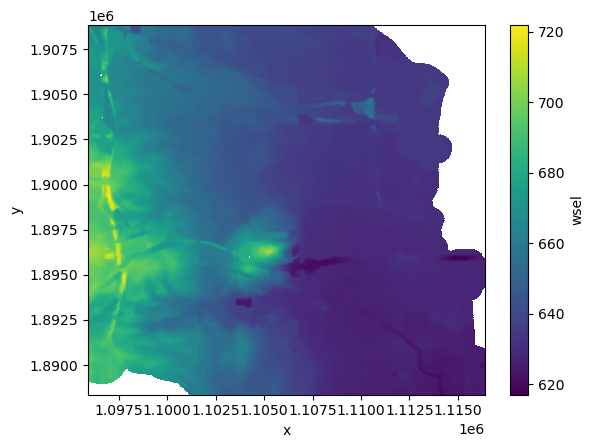

In [27]:
ds_interpolated = xr.open_zarr('./data/interpolated.zarr')
ds_interpolated.wsel.plot()

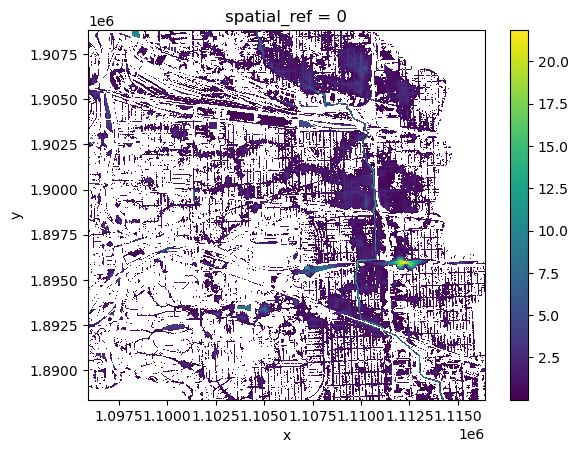

In [30]:
terrain_da_sel = terrain_da.isel(x=x_slice, y=y_slice)
depth_da = ds_interpolated.wsel - terrain_da_sel
depth_da.where(depth_da > 0).plot()

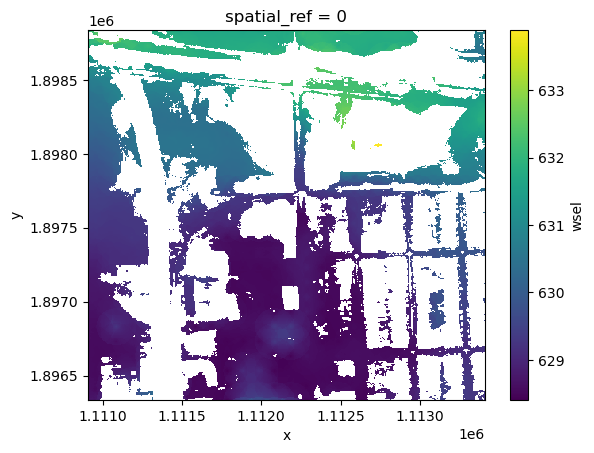

In [37]:
ds_interpolated.wsel.where(depth_da > 0).isel(x=slice(3000,3500), y=slice(2000,2500)).plot()